# Course 2: Project - Task B - Manipulating the data

<a name="task-b-top"></a>
This notebook is concerned with task B.

**Contents:**
* [Imports](#task-b-imports)
* [Data loading](#task-b-data-loading)
* [Question 1](#task-b-question-1)
* [Question 2](#task-b-question-2)
* [Question 3](#task-b-question-3)

## Imports<a name="task-e-imports"></a> ([top](#task-e-top))
---

In [1]:
# Standard library:
import math
import pathlib
import typing as t

# 3rd party:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Project:
import ingredients
import utils

%matplotlib inline
register_matplotlib_converters()

## Data loading<a name="task-e-data-loading"></a> ([top](#task-e-top))
---

First, we load the entire cleaned-up dataset:

In [2]:
base_name = pathlib.Path.cwd().joinpath('en.openfoodfacts.org.products.clean')

In [3]:
# Load the data-types:
data_types, parse_dates = utils.load_and_amend_dtypes(base_name)

# Load the data-frame:
df = pd.read_csv(
    f'{base_name}.csv',
    header=0,
    parse_dates=parse_dates,
    dtype=data_types)

We look at the first few rows:

In [4]:
utils.display_with_options(utils.ALL_COLS)(df.head())

,code,url,creator,created_on_utc,last_modified_on_utc,product_name,quantity_number,quantity_unit,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_lat,first_packaging_code_lon,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,serving_number,serving_unit
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,2016-09-17 09:17:46,2016-09-17 09:18:13,Farine de blé noir,1000.0,g,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:brands-completed,en:categories-to-be-comple...","en:brands-completed,en:categories-to-be-comple...","Brands completed,Categories to be completed,Ch...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09 14:32:37,2017-03-09 14:32:37,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,d,NaN,NaN,"en:brands-to-be-completed,en:categories-to-be-...","en:brands-to-be-completed,en:categories-to-be-...","Brands to be completed,Categories to be comple...",NaN,N

## Question 1<a name="task-b-question-1"></a> ([top](#task-b-top))
---

**Question 1:** How is the Open Food Facts project doing? In order to get a sense of how the project is doing, we want to analyze the number of unique creators per month, over the full timeline of the data.

We first create a separate data-frame with the subset that we need:

In [5]:
columns = [
    'creator',
    'created_on_utc' 
]

df_creators = df[columns]

We aggregate over time:

In [6]:
# Set the index:
df_result = df_creators.set_index('created_on_utc')

# Make sure that entries are sorted:
df_result.sort_index()

# Find the number of unique creators per month:
df_result = df_result.resample('M').nunique()

# Reset the index:
df_result = df_result.reset_index()

# Rename the columns:
df_result = df_result.rename(columns={
    'created_on_utc': 'month_end_utc',
    'creator': 'creators'
})

We display the result:

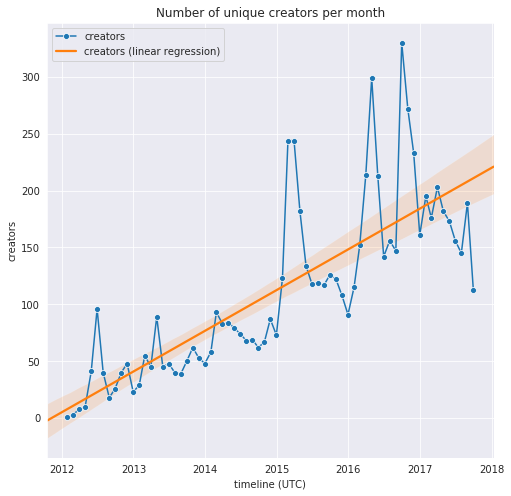

In [7]:
# For the regression plot:
df_result['month_end_utc_ordinal'] = pd.to_datetime(
    df_result['month_end_utc']).apply(lambda ts: ts.toordinal())

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(x='month_end_utc', y='creators', data=df_result,
                 ax=ax, marker='o', legend=False)
    sns.regplot(x='month_end_utc_ordinal', y='creators', data=df_result,
                ax=ax, marker='')
    ax.set_title('Number of unique creators per month')
    ax.set_xlabel('timeline (UTC)')
    ax.set_ylabel('creators')
    ax.legend(labels=['creators', 'creators (linear regression)'], loc='best')
plt.show()

**Comment:** Judging by this graph, the project seems to be doing reasonably well since the number of unique creators per month has increased over time. (With more time, it would be interesting to also look at the evolution of the average number of entries per creator.)

## Question 2<a name="task-b-question-2"></a> ([top](#task-b-top))
---

**Question 2:** What is the evolution of sugar over time? In order to answer this question, we want to analyze a) the average amount of carbohydrates and b) the average amount of the different types of carbohydrates in food products, per quarter, over the full timeline of the data. We also want to compare 2 markets - the USA and France.

Turning to the Internet, we found out that we have:

* Carbohydrates:
  * Sugars (simple)
  * Starches (complex)
  * Fibers (complex)
  * Polyols (reduced-calorie carbohydrates)
  
We first create a separate data-frame for each country with the subset that we need:

In [8]:
columns = [
    'created_on_utc',
    'carbohydrates_100g',
    'sugars_100g',
    'starch_100g',
    'fiber_100g',
    'polyols_100g'
]


def filter_country(df: pd.DataFrame, country: str) -> pd.DataFrame:
    cond_country = df['countries_tags'].str.contains(country, na=False, regex=False)
    return df[cond_country]


df_us = filter_country(df, 'united-states')[columns]
df_fr = filter_country(df, 'france')[columns]

nrows, ncols = df_us.shape
print(f"the dataset 'us' contains {nrows} row(s) and {ncols} column(s)")
nrows, ncols = df_fr.shape
print(f"the dataset 'fr' contains {nrows} row(s) and {ncols} column(s)")

the dataset 'us' contains 173439 row(s) and 6 column(s)
the dataset 'fr' contains 129239 row(s) and 6 column(s)


We get some general information about each data-frame:

In [9]:
display(utils.profile(df_us), utils.profile(df_fr))

,Types,NA,NA %,Non-NA,Non-NA %
created_on_utc,{'Timestamp': 173439},0,0.000000,173439,100.000000
carbohydrates_100g,{'float': 173439},1868,1.077036,171571,98.922964
sugars_100g,{'float': 173439},13024,7.509268,160415,92.490732
starch_100g,{'float': 173439},173438,99.999423,1,0.000577
fiber_100g,{'float': 173439},33350,19.228663,140089,80.771337
polyols_100g,{'float': 173439},173434,99.997117,5,0.002883


,Types,NA,NA %,Non-NA,Non-NA %
created_on_utc,{'Timestamp': 129239},0,0.000000,129239,100.000000
carbohydrates_100g,{'float': 129239},48463,37.498743,80776,62.501257
sugars_100g,{'float': 129239},34362,26.587949,94877,73.412051
starch_100g,{'float': 129239},129054,99.856854,185,0.143146
fiber_100g,{'float': 129239},64729,50.084727,64510,49.915273
polyols_100g,{'float': 129239},128907,99.743112,332,0.256888


As we already noticed during the clean-up (task A), only a small fraction of all rows contains information about starch and fiber, so we decide to drop the `starch_100g` and `polyols_100g` columns from our analysis.

In [10]:
columns_sugar = [
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
]

We implement an utility function to perform the analysis:

In [11]:
def process(df: pd.DataFrame, frequency: str, columns: t.List[str]) -> pd.DataFrame:
    # Set the index:
    df_result = df.set_index('created_on_utc')

    # Make sure that entries are sorted:
    df_result.sort_index()
    
    # Add an auxiliary column to the get the count per period:
    df_result['count'] = 1

    # Aggregate:
    agg_dict = {column: 'mean' for column in columns}
    agg_dict['count'] = 'count'
    df_result = df_result.resample('Q').agg(agg_dict)

    df_result.index.names = [f'{frequency.lower()}_utc']

    # Reset the index:
    df_result = df_result.reset_index()

    # Rename some columns:
    df_result = df_result.rename(columns={
        'created_on_utc': f'{frequency.lower()}_utc'
    })
    
    return df_result

In [12]:
df_us_result = process(df_us, 'Q', columns_sugar)
df_fr_result = process(df_fr, 'Q', columns_sugar)

We take a sneak peek at the result:

In [13]:
display(
    df_us_result.head(),
    df_fr_result.head()
)

,q_utc,carbohydrates_100g,sugars_100g,fiber_100g,count
0,2012-06-30,20.713333,10.080000,2.934000,6
1,2012-09-30,70.500000,12.800000,0.000000,1
2,2012-12-31,18.450000,8.900000,1.733333,5
3,2013-03-31,32.488824,11.257143,2.795000,26
4,2013-06-30,35.542059,13.909688,2.485667,59


,q_utc,carbohydrates_100g,sugars_100g,fiber_100g,count
0,2012-03-31,31.764955,13.412523,2.254878,147
1,2012-06-30,24.618511,10.916532,2.518097,1277
2,2012-09-30,31.443432,14.534192,2.229894,683
3,2012-12-31,30.193272,13.665538,2.701584,1170
4,2013-03-31,28.314489,13.439970,2.446105,1460


We implement an utility function to plot the result. We want to display the average amount of sugar per period as well as the number of products the average is based on (an average based on a small number of products should be less reliable than an average based on a large number of products): 

In [14]:
def plot_result(df: pd.DataFrame,
                data_cols: t.List[str],
                data_labels: t.List[str],
                period_col: str,
                amount_bound: t.Tuple[float, float],
                count_threshold: int,
                figtitle: str,
                figsize=(8,8)) -> None:
    with sns.axes_style('darkgrid'):
        fig, (lax, rax) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                       figsize=(8,8), gridspec_kw={'width_ratios': [4, 1]})
        
        # The left plot is for data:
        df.plot.barh(x=period_col, y=data_cols, stacked=True,
                     ax=lax, legend=True, label=data_labels)
        lax.set_xbound(amount_bound)
        lax.set_ylabel('timeline (UTC)')
        lax.legend(loc='upper left')
        lax.set_title('Avererage amount (g)')
         
        # The right plot is for the number of products:
        df.plot.barh(x=period_col, y='count',
                     ax=rax, logx=True, legend=False)
        # Set individual bar labels:
        for p in rax.patches:
            rax.text(p.get_width()+10.0, p.get_y()+.1, str(p.get_width()), color='dimgrey')
            # Highlight low values:
            if p.get_width() < count_threshold:
                p.set_color('red')
        rax.set_title('# products')
        
        # Since the y-axis is shared, we need to do this here:
        lax.set_yticklabels(df[period_col].dt.strftime('%Y-%m-%d').to_list())
        
        fig.suptitle(figtitle, y=0.95)
plt.show()

We display the result for carbohydrates:

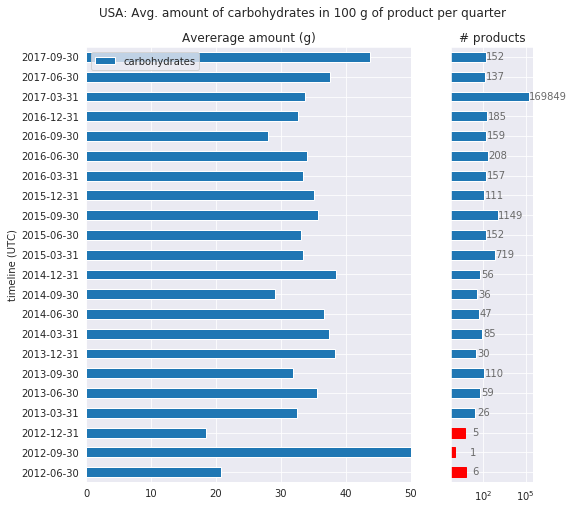

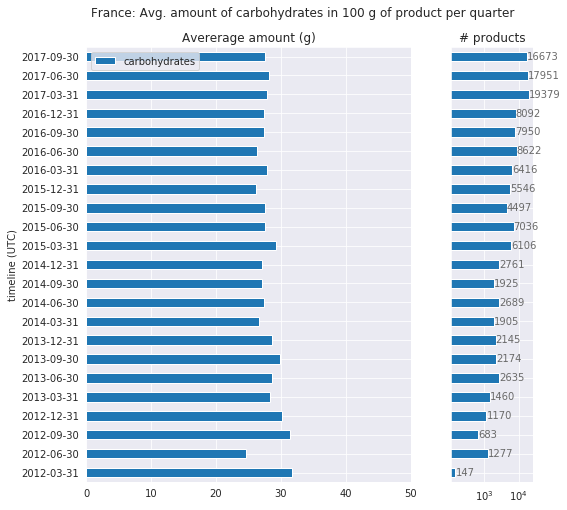

In [15]:
plot_result(df_us_result, ['carbohydrates_100g'], ['carbohydrates'], 'q_utc', (0, 50), 20,
     'USA: Avg. amount of carbohydrates in 100 g of product per quarter')
plot_result(df_fr_result, ['carbohydrates_100g'], ['carbohydrates'], 'q_utc', (0, 50), 20,
     'France: Avg. amount of carbohydrates in 100 g of product per quarter')

**Comment:** Food products in the USA contain on average more carbohydrates than products in France. Regarding the evolution (ignoring periods with less than 20 products): in the USA the amount seems to increase slightly while in France it seems to stagnate (healthier).

Finally, we display the result for sugars and fiber:

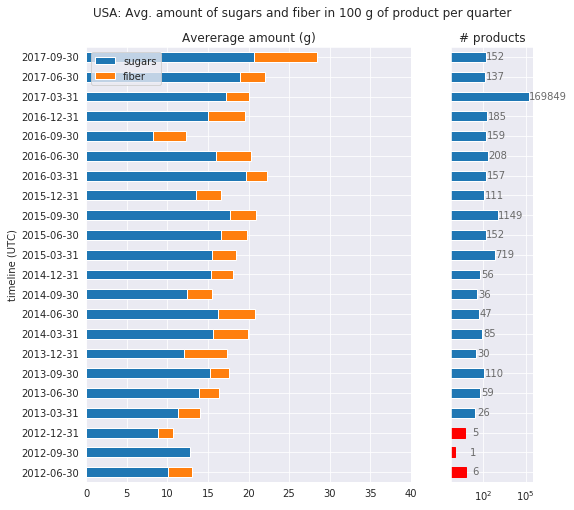

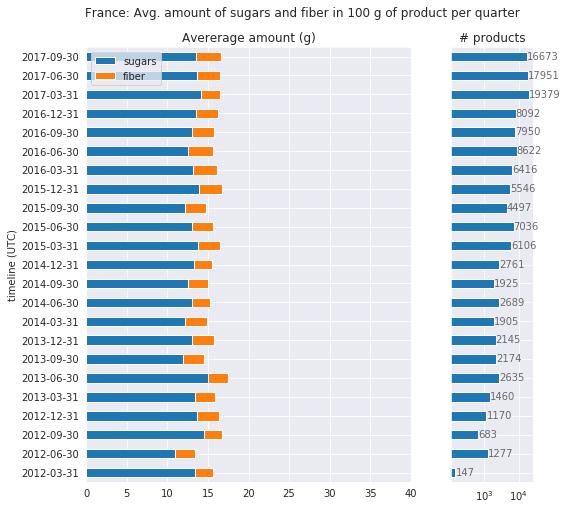

In [16]:
plot_result(df_us_result, ['sugars_100g', 'fiber_100g'], ['sugars', 'fiber'], 'q_utc', (0, 40), 20,
     'USA: Avg. amount of sugars and fiber in 100 g of product per quarter')
plot_result(df_fr_result, ['sugars_100g', 'fiber_100g'], ['sugars', 'fiber'], 'q_utc', (0, 40), 20,
     'France: Avg. amount of sugars and fiber in 100 g of product per quarter')

**Comment:** Food products in the USA contain on average more sugars and fiber than products in France (which is consistent with the result for carbohydrates above). Regarding the evolution (ignoring periods with less than 20 products): in the USA the amounts of sugars and fiber seem to increase over time while in France they seem to stagnate (healtier).

## Question 3<a name="task-b-question-3"></a> ([top](#task-b-top))
---

**Question 3:** What are the most widely used oils? In order to answer this question, we want to find the 10 oils with the highest prevalence, over the full timeline of the data, for specific groups of food products. We also want to compare 2 markets - the USA and France. Possible candidates for the groups of foods products are `main_category_en`, `pnns_groups_1` and `pnns_groups_1`. We decide to use `pnns_groups_1` as it has the smallest number of groups.

In [17]:
df['pnns_groups_1'].value_counts()

unknown                    43542
sugary-snacks              15356
beverages                  13464
milk-and-dairy-products    10745
cereals-and-potatoes       10090
fish-meat-eggs              9466
composite-foods             7971
fruits-and-vegetables       7857
fat-and-sauces              7112
salty-snacks                3300
Name: pnns_groups_1, dtype: int64

We first create a separate data-frame for each country with the subset that we need:

In [18]:
columns = [
    'pnns_groups_1',
    'ingredients_text'
]


def filter_country(df: pd.DataFrame, country: str) -> pd.DataFrame:
    is_country = df['countries_tags'].str.contains(country, na=False, regex=False)
    df_country = df[is_country & df['ingredients_text'].notna()]
    return df_country


df_us = filter_country(df, 'united-states')[columns]
df_fr = filter_country(df, 'france')[columns]

nrows, ncols = df_us.shape
print(f"the dataset 'us' contains {nrows} row(s) and {ncols} column(s)")
nrows, ncols = df_fr.shape
print(f"the dataset 'fr' contains {nrows} row(s) and {ncols} column(s)")

the dataset 'us' contains 171605 row(s) and 2 column(s)
the dataset 'fr' contains 86654 row(s) and 2 column(s)


We check the number of rows where `pnns_groups_1` is non-NA:

In [19]:
display(
    df_us['pnns_groups_1'].notna().sum(),
    df_fr['pnns_groups_1'].notna().sum()
)

2859

84478

We first figure out the the distribution of the food groups:

In [20]:
df_pnns_us = df_us.groupby(by='pnns_groups_1').count().rename(columns={'ingredients_text': 'count'})
df_pnns_us = df_pnns_us.sort_index()
df_pnns_us['fraction'] = df_pnns_us['count'] / df_pnns_us['count'].sum()

df_pnns_fr = df_fr.groupby(by='pnns_groups_1').count().rename(columns={'ingredients_text': 'count'})
df_pnns_fr = df_pnns_fr.sort_index()
df_pnns_fr['fraction'] = df_pnns_fr['count'] / df_pnns_fr['count'].sum()

We implement an utility function to plot the distribution of the food groups:

In [21]:
def plot_pnns_distribution(df: pd.DataFrame, title: str) -> None:
    with sns.axes_style('darkgrid'):
        cmap = plt.cm.get_cmap('tab20', len(df))
        fig, ax = plt.subplots(figsize=(5,5))
        ax = df.plot.pie(y='fraction', label='', labels=None, shadow=False, ax=ax, cmap=cmap)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        # Cosmetic hack to get a doughnut pie:
        circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
        ax.add_artist(circle)
        labels = [f"{index} {row['fraction'] * 100:.1f} %" for index, row in df.iterrows()]
        plt.legend(labels=labels, bbox_to_anchor=(1,0.9))
        ax.set_title(title)
    plt.show()

We display the result for both the USA and France:

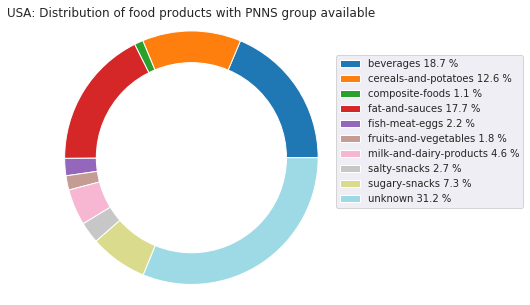

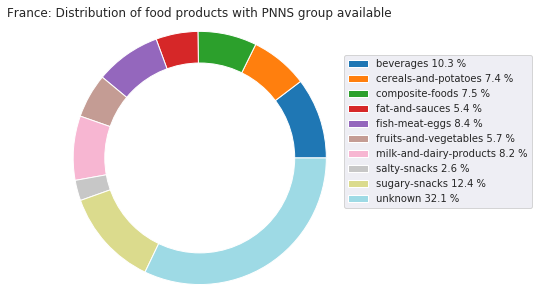

In [22]:
plot_pnns_distribution(df_pnns_us, 'USA: Distribution of food products with PNNS group available')
plot_pnns_distribution(df_pnns_fr, 'France: Distribution of food products with PNNS group available')

We break each data-frame into multiple data-frames, one per group:

In [23]:
def partition(df: pd.DataFrame, by_col: str) -> t.List[t.Tuple[str, pd.DataFrame]]:
    result = []
    categories = df[by_col].unique()
    for category in categories:
        if pd.isna(category):
            continue
        else:
            part = df[df[by_col] == category]
            result.append((category, part))
    return result

In [24]:
parts_us = partition(df_us, 'pnns_groups_1')
parts_fr = partition(df_fr, 'pnns_groups_1')

We use task C to get the list of ingredients:

In [25]:
# Order matters due to substrings:
delims_en = ['and/or', 'or/and', 'and', 'or']
delims_fr = ['et/ou', 'ou/et', 'et',  'ou']

In [26]:
def parts_to_ingredients(parts: t.List[t.Tuple[str, pd.DataFrame]], delims: t.List[str]) -> t.List[t.Tuple[str, pd.DataFrame]]:
    result = []
    for part in parts:
        part_cat, part_df = part
        ingredients_df = ingredients.texts_to_ingredients_df(part_df['ingredients_text'], delims)
        ingredients_df = ingredients.reconcile_composite(ingredients_df, 0.5)
        result.append((part_cat, ingredients_df))
    return result

In [27]:
df_us_ingredients = parts_to_ingredients(parts_us, delims_en)
df_fr_ingredients = parts_to_ingredients(parts_fr, delims_fr)

We implement an utility function to filter rows related to oils, compute the prevalence of each oil and get the top N oils: 

In [28]:
def top_n(parts: t.Tuple[str, pd.DataFrame], n: int, oil: str) -> t.List[t.Tuple[str, pd.DataFrame, int]]:
    result = []
    for part in parts:
        part_cat, part_df = part
        # Keep only ingredients with oil:
        oil_df = part_df[part_df.index.str.contains(oil, na=False, regex=False)]
        # Sort by count in descending order:
        oil_df = oil_df.sort_values(by='count', ascending=False)
        # Ignore "composite" ingredients (e.g. "vegetable oil"):
        oil_df = oil_df[~oil_df['is_composite']]
        # Compute prevalence:
        oil_df['prevalence'] = oil_df['count'] / oil_df['count'].sum() * 100.0
        # Top N:
        oil_df = oil_df.head(n)[['count', 'prevalence']]
        oil_total = oil_df['count'].sum()
        result.append((part_cat, oil_df, oil_total))
    return result

In [29]:
top10_us = top_n(df_us_ingredients, 10, 'oil')
top10_fr = top_n(df_fr_ingredients, 10, 'huile')

We implement an utility function to plot the 10 most prevalent oils in each food group:

In [30]:
def plot_oils(topN: t.List[t.Tuple[str, pd.DataFrame, int]], prefix: str) -> None:
    ncols = 1
    nrows = math.ceil(len(top10_us) / ncols)
    fig = plt.figure(figsize=(6, nrows * 4))
    grid = plt.GridSpec(nrows, ncols, wspace=0.4, hspace=0.6)
    for i, part in enumerate(topN):
        row, col = i // ncols, i % ncols
        ax = fig.add_subplot(grid[row, col])
        part_cat, part_df, part_total = part
        ax.set_title(f'{prefix}: {part_cat} ({part_total} products)')
        part_df[['prevalence']].plot.barh(y='prevalence', ax=ax)
        ax.invert_yaxis()
        ax.set_ylabel('')

We display the result for the USA:

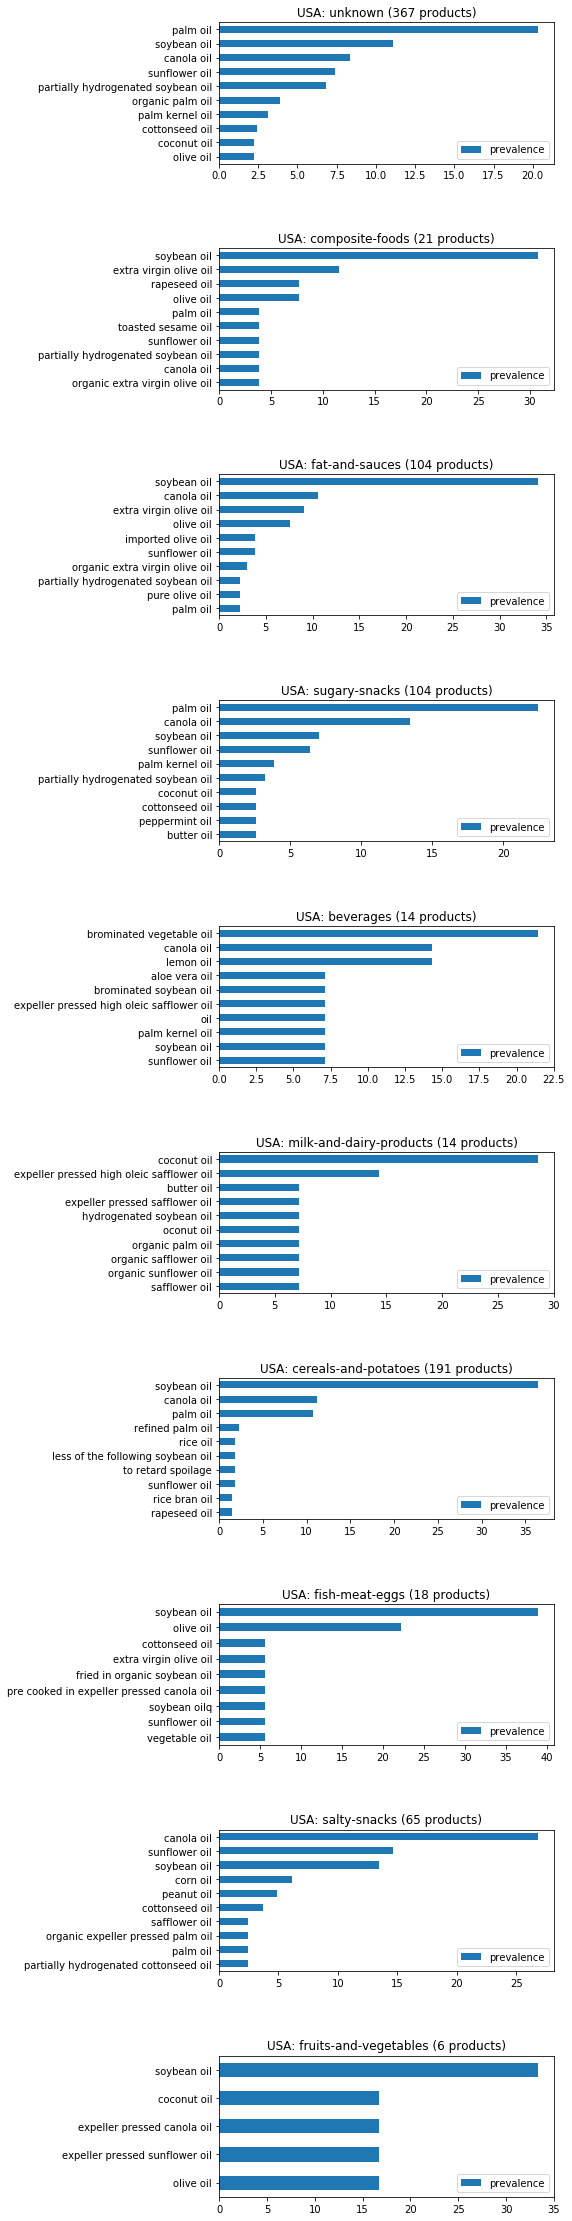

In [31]:
plot_oils(top10_us, 'USA')

**Comment:** For the USA, at the top of the charts we find palm oil, soybean oil, brominated vegetable oil, coconut oil and canola oil. Turning to the Internet, we found out that palm oil, soybean oil, brominated vegetable oil and canola oil are mass-produced and/or from GMO crops and/or known to have adverserial health effects. Palm oil seems to be the least harmful but there are ethical concerns related to it.

Here is the result for France:

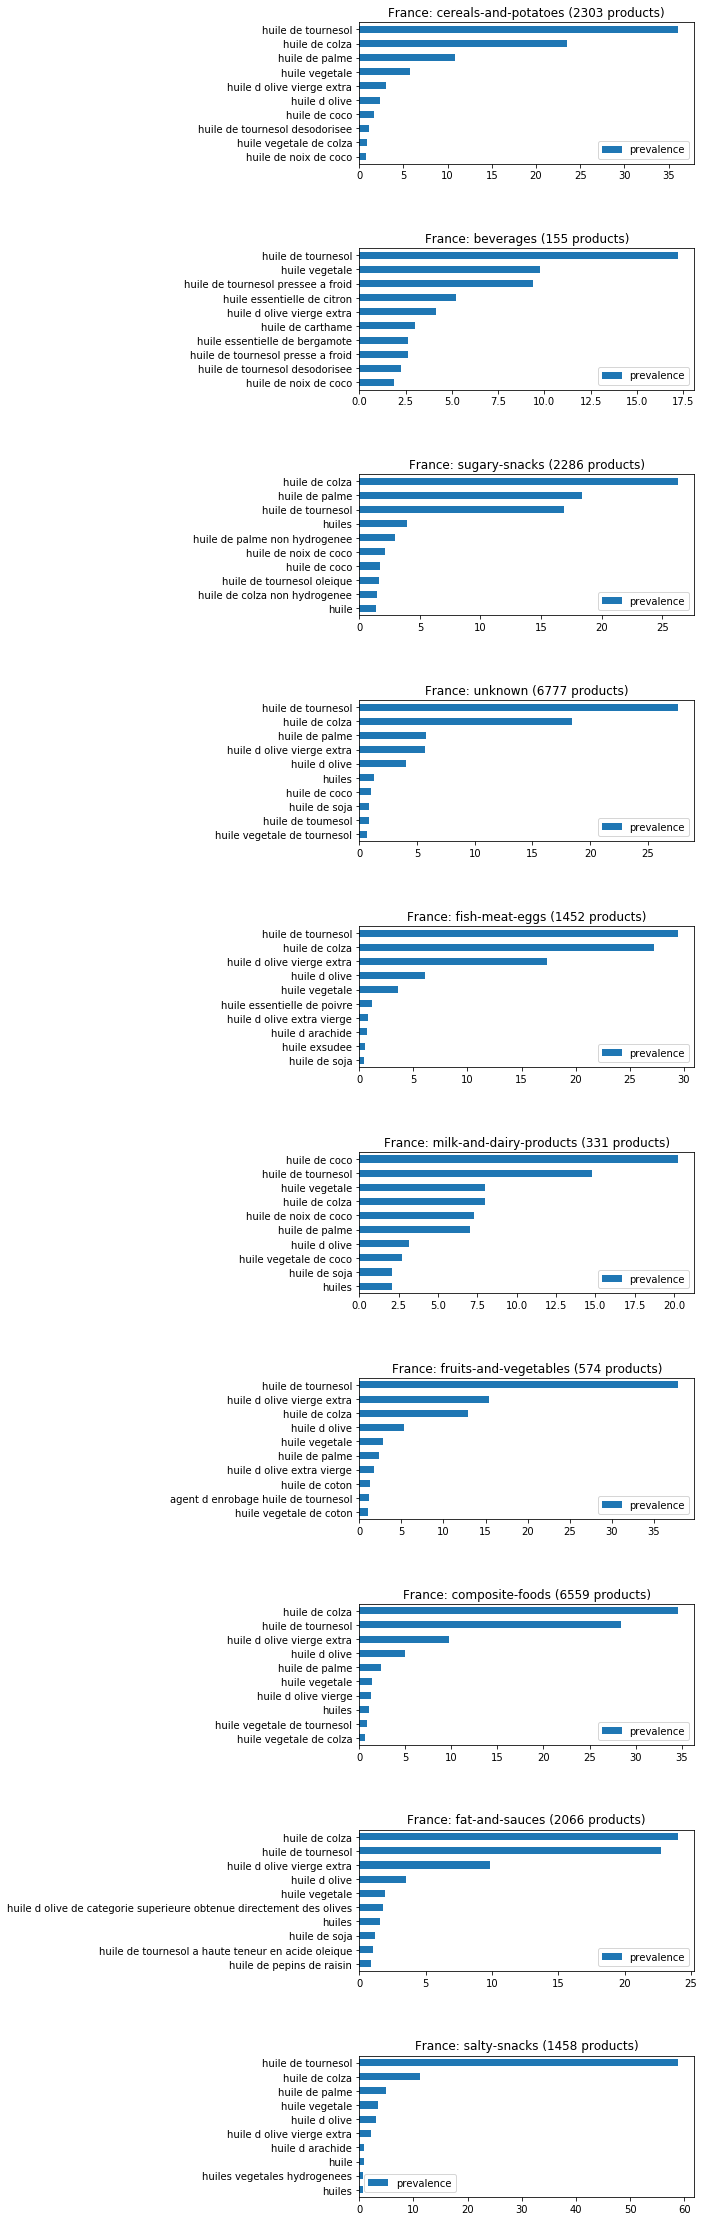

In [32]:
plot_oils(top10_fr, 'France')

**Comment:** For France, at the top of the charts we find *huile de tournesol* (sunflower oil), *huil de colza* (canola oil) and *huile de coco* (coconut oil). Turning to the Internet, we found out that sunflower oil seems to be a good all-purpose oil. In conclusion, food products in France appear to contain healthier oils than in the USA.